In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import yfinance as yf

In [2]:
tsla_price = pd.read_excel("tsla price.xlsx")
oil_price = pd.read_excel("oil price.xlsx")
ten_yr_yield_interest_rate = pd.read_excel("interest rate.xlsx")

tsla_price['Date'] = pd.to_datetime(tsla_price['Date'])
oil_price['Date'] = pd.to_datetime(oil_price['Date'])
ten_yr_yield_interest_rate['Date'] = pd.to_datetime(ten_yr_yield_interest_rate['Date'])

df = tsla_price[['Date', 'Last Price', 'BEst EPS']].merge(
    oil_price[['Date', 'Last Price']], on='Date', suffixes=('_tsla', '_oil')
).merge(
    ten_yr_yield_interest_rate[['Date', 'Last Price']], on='Date'
)

df.rename(columns={'Last Price_tsla': 'TSLA_Price', 
                   'Last Price_oil': 'Oil_Price', 
                   'Last Price': 'Ten_Year_Yield_Interest_Rate', 
                   'BEst EPS': 'EPS_Estimate'}, inplace=True)

print(df)

           Date  TSLA_Price  EPS_Estimate  Oil_Price  \
0    2025-02-27    283.7500         3.060      70.32   
1    2025-02-26    290.8000         3.056      68.62   
2    2025-02-25    302.8000         3.052      68.93   
3    2025-02-24    330.5300         3.048      70.70   
4    2025-02-21    337.8000         3.018      70.40   
...         ...         ...           ...        ...   
2531 2015-01-08     14.0410         0.093      48.79   
2532 2015-01-07     14.0633         0.093      48.65   
2533 2015-01-06     14.0853         0.092      47.93   
2534 2015-01-05     14.0060         0.091      50.04   
2535 2015-01-02     14.6207         0.091      52.69   

      Ten_Year_Yield_Interest_Rate  
0                           4.2848  
1                           4.2562  
2                           4.2945  
3                           4.4003  
4                           4.4313  
...                            ...  
2531                        2.0179  
2532                        1.9

In [3]:
df.set_index('Date', inplace=True)
df_monthly = df.resample('ME').last()

eps_shift = abs(df_monthly['EPS_Estimate'].min()) + 1
df_monthly['EPS_Adjusted'] = df_monthly['EPS_Estimate'] + eps_shift

df_monthly['TSLA_Return'] = df_monthly['TSLA_Price'].pct_change()
df_monthly['Oil_Return'] = df_monthly['Oil_Price'].pct_change()
df_monthly['Ten_Year_Yield_Interest_Rate_Return'] = df_monthly['Ten_Year_Yield_Interest_Rate'].pct_change()
df_monthly['EPS_Return'] = df_monthly['EPS_Adjusted'].pct_change()

df_monthly.dropna(inplace=True)

In [4]:
#Holding Period 变量计算的是 过去 X 个月的累计回报率，用于衡量长期趋势，而不是单月回报率。变量原始值的收益率更和特斯拉收益率更具相关性
df_monthly[f'Oil_Return_Holding_Period_3M'] = (1 + df_monthly['Oil_Return']).rolling(window=3).apply(lambda x: x.prod(), raw=True) - 1
df_monthly[f'Oil_Return_Holding_Period_2M'] = (1 + df_monthly['Oil_Return']).rolling(window=2).apply(lambda x: x.prod(), raw=True) - 1
# df_monthly[f'Ten_Year_Yield_Interest_Rate_Return_Holding_Period_1M'] = (1 + df_monthly['Ten_Year_Yield_Interest_Rate_Return']).rolling(window=1).apply(lambda x: x.prod(), raw=True) - 1
# df_monthly[f'EPS_Return_Holding_Period_1M'] = (1 + df_monthly['EPS_Return']).rolling(window=3).apply(lambda x: x.prod(), raw=True) - 1

df_monthly.dropna(inplace=True)

correlation_matrix = df_monthly.corr().loc[
    df_monthly.columns.str.startswith(('Oil_Return_Holding_Period_1M', 
                                       'Ten_Year_Yield_Interest_Rate_Return_Holding_Period_1M', 
                                       'EPS_Return_Holding_Period_1M')),
    df_monthly.columns.str.startswith('TSLA_Return')
]

print('TSLA_Return')

print(correlation_matrix)


TSLA_Return
Empty DataFrame
Columns: [TSLA_Return]
Index: []


In [5]:
#检验哪些变量对TSLA 未来 1 个月的收益率有预测能力
df_monthly[f'TSLA_Return_Future_Lag_1M'] = df_monthly['TSLA_Return'].shift(-1)

df_monthly.dropna(inplace=True)

correlation_matrix = df_monthly.corr().loc[:, df_monthly.columns.str.startswith('TSLA_Return_Future_Lag')]

print(correlation_matrix)

                                     TSLA_Return_Future_Lag_1M
TSLA_Price                                           -0.124096
EPS_Estimate                                         -0.076612
Oil_Price                                            -0.173884
Ten_Year_Yield_Interest_Rate                         -0.197609
EPS_Adjusted                                         -0.076612
TSLA_Return                                           0.043732
Oil_Return                                            0.041363
Ten_Year_Yield_Interest_Rate_Return                  -0.062622
EPS_Return                                            0.113237
Oil_Return_Holding_Period_3M                          0.110323
Oil_Return_Holding_Period_2M                          0.057565
TSLA_Return_Future_Lag_1M                             1.000000


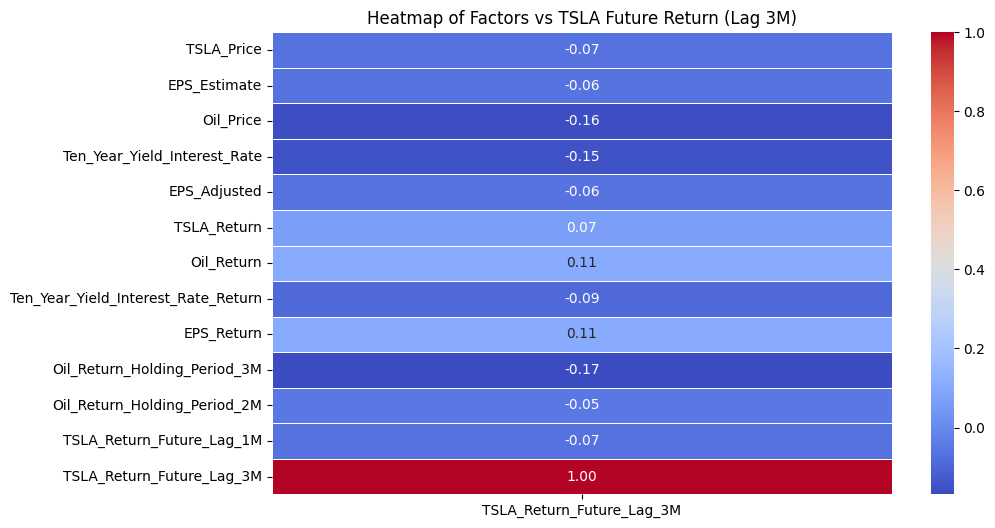

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

if 'df_monthly' in locals() or 'df_monthly' in globals():
    df_monthly['TSLA_Return_Future_Lag_3M'] = df_monthly['TSLA_Return'].shift(-3)
    df_monthly.dropna(inplace=True)

    correlation_matrix_3M = df_monthly.corr().loc[:, ['TSLA_Return_Future_Lag_3M']]

    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation_matrix_3M, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

    plt.title("Heatmap of Factors vs TSLA Future Return (Lag 3M)")

    plt.show()
else:
    print("Error: df_monthly is not defined. Please run the data preparation steps first.")


In [7]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

train_window = 36  
df_signals = pd.DataFrame(index=df_monthly.index[train_window:])

for i in range(train_window, len(df_monthly) - 1):
    train_X = df_monthly.iloc[i - train_window:i].drop(columns=['TSLA_Return_Future_Lag_1M', 'TSLA_Price', 'EPS_Estimate', 'Oil_Price'])
    train_y = df_monthly.iloc[i - train_window:i]['TSLA_Return_Future_Lag_1M']
    
    train_columns = train_X.columns  

    model = LinearRegression()
    model.fit(train_X, train_y)

    test_X = df_monthly.iloc[i][train_columns].values.reshape(1, -1)
    predicted_return = model.predict(test_X)[0]

    df_signals.loc[df_monthly.index[i], 'Predicted_Lag1_Return'] = predicted_return
    df_signals.loc[df_monthly.index[i], 'Signal'] = 1 if predicted_return > 0 else -1

print(df_signals)

c:\Users\wzy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\wzy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\wzy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\wzy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\wzy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegressi

            Predicted_Lag1_Return  Signal
Date                                     
2018-04-30               0.065282     1.0
2018-05-31               0.000122     1.0
2018-06-30               0.165769     1.0
2018-07-31              -0.083315    -1.0
2018-08-31               0.019088     1.0
...                           ...     ...
2024-06-30              -0.033137    -1.0
2024-07-31               0.059712     1.0
2024-08-31               0.007268     1.0
2024-09-30               0.037825     1.0
2024-10-31                    NaN     NaN

[79 rows x 2 columns]


c:\Users\wzy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\wzy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\wzy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\wzy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\wzy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegressi

In [8]:
import numpy as np
import matplotlib.pyplot as plt

df_signals['real_future_return'] = df_monthly.loc[df_signals.index, 'TSLA_Return_Future_Lag_1M']

df_signals['strategy_return'] = df_signals['real_future_return'] * df_signals['Signal'].shift(1)

df_signals['cumulative_real_tesla_return'] = (1 + df_signals['real_future_return']).cumprod()
df_signals['cumulative_strategy_return'] = (1 + df_signals['strategy_return']).cumprod()

df_signals['Cumulative_Strategy_Return (%)'] = (df_signals['cumulative_strategy_return'] - 1) * 100
df_signals['Cumulative_Real_Tesla_Return (%)'] = (df_signals['cumulative_real_tesla_return'] - 1) * 100

print(df_signals[['Predicted_Lag1_Return', 'Signal', 'real_future_return', 'strategy_return', 
                  'Cumulative_Strategy_Return (%)', 'Cumulative_Real_Tesla_Return (%)']])

            Predicted_Lag1_Return  Signal  real_future_return  \
Date                                                            
2018-04-30               0.065282     1.0           -0.031199   
2018-05-31               0.000122     1.0            0.204473   
2018-06-30               0.165769     1.0           -0.130659   
2018-07-31              -0.083315    -1.0            0.011808   
2018-08-31               0.019088     1.0           -0.122293   
...                           ...     ...                 ...   
2024-06-30              -0.033137    -1.0            0.172781   
2024-07-31               0.059712     1.0           -0.077390   
2024-08-31               0.007268     1.0            0.221942   
2024-09-30               0.037825     1.0           -0.045025   
2024-10-31                    NaN     NaN            0.381469   

            strategy_return  Cumulative_Strategy_Return (%)  \
Date                                                          
2018-04-30              NaN 

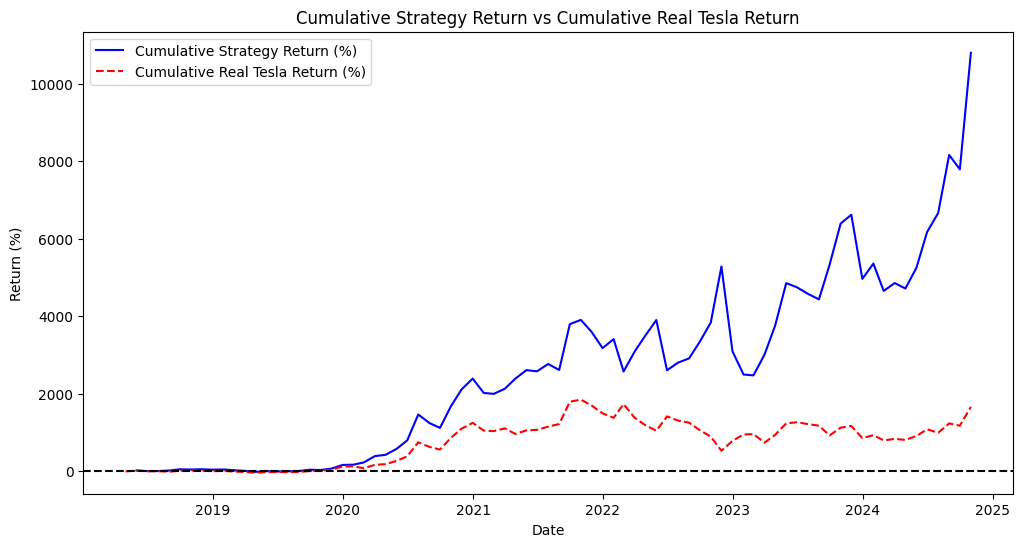

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(df_signals.index, df_signals['Cumulative_Strategy_Return (%)'], label="Cumulative Strategy Return (%)", color="blue")
plt.plot(df_signals.index, df_signals['Cumulative_Real_Tesla_Return (%)'], label="Cumulative Real Tesla Return (%)", color="red", linestyle="--")

plt.axhline(0, color="black", linestyle="--")

plt.title("Cumulative Strategy Return vs Cumulative Real Tesla Return")
plt.xlabel("Date")
plt.ylabel("Return (%)")
plt.legend()

plt.show()


## Step 8: Walk-Forward Optimization

In this section, we generate backtested signals using walk-forward optimization. The model reoptimizes hyperparameters **once per year** using rolling training windows. Hyperparameters include:

- Regression model type (`LinearRegression`, `Ridge`, `Lasso`)
- Regularization parameter (`alpha`)
- Training window size (24, 36, or 48 months)
- Feature set


In [10]:

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from dateutil.relativedelta import relativedelta

In [11]:
sp500 = yf.download('^GSPC', start='2015-01-01', end='2025-03-01')
# sp500.reset_index(inplace=True)
# sp500 = sp500[['Date', 'Close']]
# sp500.rename(columns={'Close': 'SP500_Price'}, inplace=True)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [12]:
sp500 = yf.download('GSPC', start='2015-01-01', end='2025-03-01')

404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/GSPC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=GSPC&crumb=Y6G7lTEDZKc
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GSPC']: AttributeError("'NoneType' object has no attribute 'update'")


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import os
import datetime
import yfinance as yf

# ----------- Data Preparation Functions -------------
def load_data():
    tsla_price = pd.read_excel("tsla price.xlsx")
    oil_price = pd.read_excel("oil price.xlsx")
    interest_rate = pd.read_excel("interest rate.xlsx")

    tsla_price['Date'] = pd.to_datetime(tsla_price['Date'])
    oil_price['Date'] = pd.to_datetime(oil_price['Date'])
    interest_rate['Date'] = pd.to_datetime(interest_rate['Date'])

    if 'Date.1' in tsla_price.columns:
        tsla_price.drop(columns=['Date.1'], inplace=True)

    df = tsla_price[['Date', 'Last Price', 'BEst EPS']].merge(
        oil_price[['Date', 'Last Price']], on='Date', how='inner', suffixes=('_tsla', '_oil')
    ).merge(
        interest_rate[['Date', 'Last Price']], on='Date', how='inner'
    )

    df.rename(columns={
        'Last Price_tsla': 'TSLA_Price',
        'Last Price_oil': 'Oil_Price',
        'Last Price': 'Ten_Year_Yield_Interest_Rate',
        'BEst EPS': 'EPS_Estimate'
    }, inplace=True)

    # Add SP500 data
    try:
        sp500 = yf.download('^GSPC', start='2015-01-01', end='2025-03-01')
        sp500.columns = sp500.columns.droplevel(1)
        sp500.reset_index(inplace=True)
        sp500 = sp500[['Date', 'Close']]
        sp500.rename(columns={'Close': 'SP500_Price'}, inplace=True)
        df = df.merge(sp500, on='Date', how='left')
    except:
        df['SP500_Price'] = np.nan

    # Add risk-free rate
    try:
        risk_free = pd.read_csv("DGS1.csv")
        risk_free['DATE'] = pd.to_datetime(risk_free['DATE'])
        risk_free.rename(columns={'DATE': 'Date', 'DGS1': 'Risk_Free_Rate'}, inplace=True)
        df = df.merge(risk_free[['Date', 'Risk_Free_Rate']], on='Date', how='left')
    except:
        df['Risk_Free_Rate'] = 0.01

    return df

def prepare_monthly_data(df):
    df.set_index('Date', inplace=True)
    df_monthly = df.resample('M').last().copy()
    df_monthly.ffill(inplace=True)

    # EPS 调整为正值以便计算 log return
    eps_shift = abs(df_monthly['EPS_Estimate'].min()) + 1 if df_monthly['EPS_Estimate'].min() < 0 else 0
    df_monthly['EPS_Adjusted'] = df_monthly['EPS_Estimate'] + eps_shift

    # Return 计算
    df_monthly['TSLA_Return'] = df_monthly['TSLA_Price'].pct_change()
    df_monthly['Oil_Return'] = df_monthly['Oil_Price'].pct_change()
    df_monthly['Ten_Year_Yield_Interest_Rate_Return'] = df_monthly['Ten_Year_Yield_Interest_Rate'].pct_change()
    df_monthly['EPS_Return'] = df_monthly['EPS_Adjusted'].pct_change()
    if 'SP500_Price' in df_monthly.columns:
        df_monthly['SP500_Return'] = df_monthly['SP500_Price'].pct_change()

    # Holding period returns
    df_monthly['Oil_Return_Holding_Period_3M'] = (1 + df_monthly['Oil_Return']).rolling(3).apply(np.prod, raw=True) - 1
    df_monthly['Oil_Return_Holding_Period_2M'] = (1 + df_monthly['Oil_Return']).rolling(2).apply(np.prod, raw=True) - 1
    df_monthly['Ten_Year_Yield_Interest_Rate_Return_Holding_Period_2M'] = \
        (1 + df_monthly['Ten_Year_Yield_Interest_Rate_Return']).rolling(2).apply(np.prod, raw=True) - 1

    df_monthly['TSLA_Return_Future_Lag_1M'] = df_monthly['TSLA_Return'].shift(-1)

    return df_monthly

# ----------- Run and Save Data -------------
df_raw = load_data()
df_monthly = prepare_monthly_data(df_raw)

df_monthly.to_csv("df_monthly.csv")
print(" Monthly dataset saved to df_monthly.csv")


[*********************100%***********************]  1 of 1 completed

 Monthly dataset saved to df_monthly.csv



C:\Users\wzy\AppData\Local\Temp\ipykernel_40936\1738630692.py:61: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M').last().copy()


In [14]:
df_monthly = df_monthly.apply(pd.to_numeric, errors='coerce')
print(df_monthly.dtypes) 


TSLA_Price                                               float64
EPS_Estimate                                             float64
Oil_Price                                                float64
Ten_Year_Yield_Interest_Rate                             float64
SP500_Price                                              float64
Risk_Free_Rate                                           float64
EPS_Adjusted                                             float64
TSLA_Return                                              float64
Oil_Return                                               float64
Ten_Year_Yield_Interest_Rate_Return                      float64
EPS_Return                                               float64
SP500_Return                                             float64
Oil_Return_Holding_Period_3M                             float64
Oil_Return_Holding_Period_2M                             float64
Ten_Year_Yield_Interest_Rate_Return_Holding_Period_2M    float64
TSLA_Return_Future_Lag_1M

In [15]:
def walk_forward_optimization(df_monthly, initial_train_window=36, test_start_date='2020-01-31'):
    test_start_date = pd.to_datetime(test_start_date)
    df_signals = pd.DataFrame(index=df_monthly.index[df_monthly.index >= test_start_date])

    hyperparameters_over_time = {
        'Date': [], 'Train_Window': [], 'Alpha_Value': [],
        'Model_Type': [], 'Selected_Features': []
    }

    feature_sets = [
        ['TSLA_Return', 'Oil_Return', 'Ten_Year_Yield_Interest_Rate_Return', 'EPS_Return'],
        ['TSLA_Return', 'Oil_Return', 'Ten_Year_Yield_Interest_Rate_Return', 'EPS_Return',
         'Oil_Return_Holding_Period_3M', 'Oil_Return_Holding_Period_2M',
         'Ten_Year_Yield_Interest_Rate_Return_Holding_Period_2M'],
        ['Oil_Return', 'Ten_Year_Yield_Interest_Rate_Return', 'EPS_Return'],
        ['Oil_Return_Holding_Period_3M', 'Oil_Return_Holding_Period_2M',
         'Ten_Year_Yield_Interest_Rate_Return_Holding_Period_2M']
    ]

    model_types = ['LinearRegression', 'Ridge', 'Lasso']
    train_windows = [24, 36, 48]
    alphas = [0.01, 0.1, 1.0, 10.0]

    test_dates = df_monthly.index[df_monthly.index >= test_start_date]
    current_date = test_start_date
    reoptimization_dates = []

    while current_date <= df_monthly.index.max():
        reoptimization_dates.append(current_date)
        current_date += relativedelta(years=1)

    best_train_window = initial_train_window
    best_model_type = 'LinearRegression'
    best_feature_set = feature_sets[0]
    best_alpha = 0.1
    last_optimization_date = pd.to_datetime('1900-01-01')

    imputer = SimpleImputer(strategy='mean')

    for test_date in test_dates:
        if any(test_date >= ro and ro > last_optimization_date for ro in reoptimization_dates):
            last_optimization_date = test_date
            best_mse = float('inf')

            available_data = df_monthly[df_monthly.index < test_date]
            for train_window in train_windows:
                if len(available_data) < train_window: continue
                for feature_set in feature_sets:
                    for model_type in model_types:
                        alpha_values = [0] if model_type == 'LinearRegression' else alphas
                        for alpha in alpha_values:
                            tscv = TimeSeriesSplit(n_splits=min(5, len(available_data) - train_window))
                            mse_scores = []
                            for train_idx, val_idx in tscv.split(available_data):
                                if len(train_idx) < train_window: continue
                                train_data = available_data.iloc[train_idx[-train_window:]]
                                val_data = available_data.iloc[val_idx]

                                X_train = train_data[feature_set].copy()
                                y_train = train_data['TSLA_Return_Future_Lag_1M'].copy()
                                X_val = val_data[feature_set].copy()
                                y_val = val_data['TSLA_Return_Future_Lag_1M'].copy()

                                if X_train.isna().any().any() or y_train.isna().any(): continue
                                if X_val.isna().any().any() or y_val.isna().any(): continue

                                X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=feature_set)
                                X_val = pd.DataFrame(imputer.transform(X_val), columns=feature_set)

                                if model_type == 'LinearRegression':
                                    model = LinearRegression()
                                elif model_type == 'Ridge':
                                    model = Ridge(alpha=alpha)
                                else:
                                    model = Lasso(alpha=alpha)

                                model.fit(X_train, y_train)
                                y_pred = model.predict(X_val)
                                mse_scores.append(mean_squared_error(y_val, y_pred))

                            if mse_scores:
                                avg_mse = np.mean(mse_scores)
                                if avg_mse < best_mse:
                                    best_mse = avg_mse
                                    best_train_window = train_window
                                    best_model_type = model_type
                                    best_feature_set = feature_set
                                    best_alpha = alpha

            hyperparameters_over_time['Date'].append(test_date)
            hyperparameters_over_time['Train_Window'].append(best_train_window)
            hyperparameters_over_time['Alpha_Value'].append(best_alpha)
            hyperparameters_over_time['Model_Type'].append(best_model_type)
            hyperparameters_over_time['Selected_Features'].append(','.join(best_feature_set))

        train_end_idx = df_monthly.index.get_loc(test_date)
        train_start_idx = max(0, train_end_idx - best_train_window)
        train_data = df_monthly.iloc[train_start_idx:train_end_idx]

        X_train = pd.DataFrame(imputer.fit_transform(train_data[best_feature_set]), columns=best_feature_set)
        y_train = train_data['TSLA_Return_Future_Lag_1M']
        model = {'LinearRegression': LinearRegression(),
                 'Ridge': Ridge(alpha=best_alpha),
                 'Lasso': Lasso(alpha=best_alpha)}[best_model_type]
        model.fit(X_train, y_train)

        X_test = df_monthly.loc[[test_date], best_feature_set]
        X_test = pd.DataFrame(imputer.transform(X_test), columns=best_feature_set)
        y_pred = model.predict(X_test)[0]

        df_signals.loc[test_date, 'Predicted_Return'] = y_pred
        df_signals.loc[test_date, 'Signal'] = 1 if y_pred > 0 else -1
        df_signals.loc[test_date, 'Actual_Return'] = df_monthly.loc[test_date, 'TSLA_Return']
        df_signals.loc[test_date, 'TSLA_Price'] = df_monthly.loc[test_date, 'TSLA_Price']
        df_signals.loc[test_date, 'Oil_Price'] = df_monthly.loc[test_date, 'Oil_Price']
        df_signals.loc[test_date, 'Ten_Year_Yield_Interest_Rate'] = df_monthly.loc[test_date, 'Ten_Year_Yield_Interest_Rate']
        df_signals.loc[test_date, 'EPS_Estimate'] = df_monthly.loc[test_date, 'EPS_Estimate']
        df_signals.loc[test_date, 'SP500_Return'] = df_monthly.loc[test_date, 'SP500_Return']


    return df_signals, pd.DataFrame(hyperparameters_over_time)


In [16]:
signals_df, hyperparams_df = walk_forward_optimization(df_monthly)
signals_df.to_csv("signals.csv")
hyperparams_df.to_csv("hyperparameters.csv", index=False)

signals_df.head()


,Predicted_Return,Signal,Actual_Return,TSLA_Price,Oil_Price,Ten_Year_Yield_Interest_Rate,EPS_Estimate,SP500_Return
Date,,,,,,,,
2020-01-31,0.023866,1.0,0.555157,43.3713,51.56,1.5068,0.338,-0.001628
2020-02-29,0.030341,1.0,0.026778,44.5327,44.76,1.1486,0.434,-0.084110
2020-03-31,-0.015588,-1.0,-0.215558,34.9333,20.48,0.6695,0.483,-0.125119
2020-04-30,0.065914,1.0,0.492138,52.1253,18.84,0.6393,0.538,0.126844
2020-05-31,-0.042348,-1.0,0.067940,55.6667,35.49,0.6526,0.805,0.045282


## Step 9: Visualizing Forecast Signals and Hyperparameters

This section visualizes the trading signals, forecasted returns, and the evolution of hyperparameters over time. We will:
1. Plot forecast signals over fundamental indicators and TSLA price.
2. Analyze how the model's hyperparameters evolved during the backtesting period.


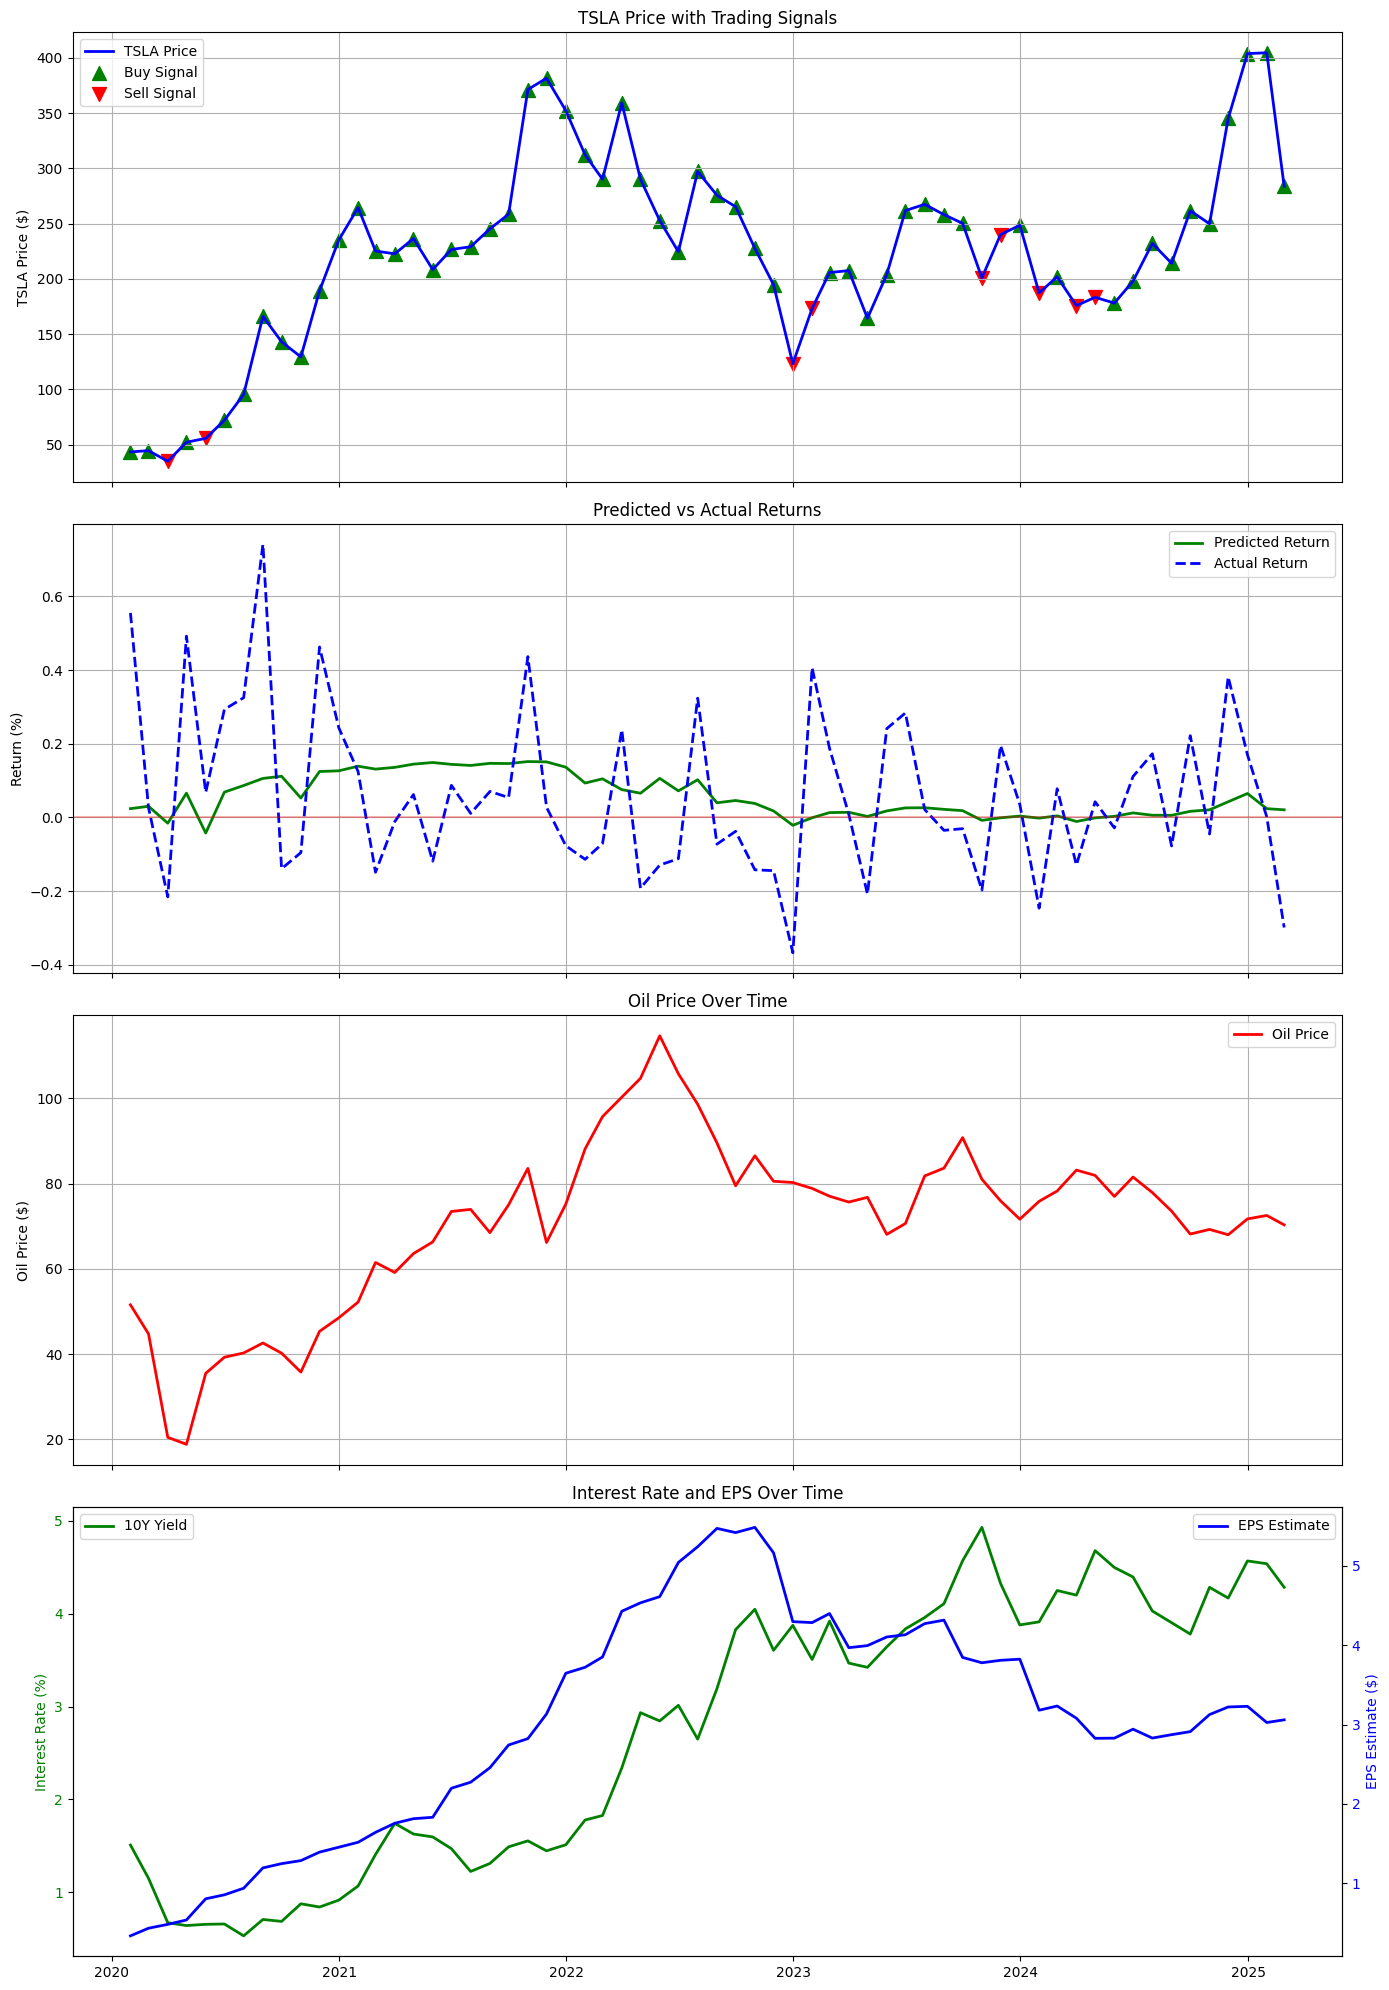

In [17]:
def plot_forecast_signals(signals_df):
    """
    Plot forecast signals, predicted returns, actual returns, and fundamental variables.
    """
    fig, axes = plt.subplots(4, 1, figsize=(14, 20), sharex=True)

    axes[0].plot(signals_df.index, signals_df['TSLA_Price'], 'b-', linewidth=2, label='TSLA Price')

    buy_signals = signals_df[signals_df['Signal'] == 1]
    sell_signals = signals_df[signals_df['Signal'] == -1]

    axes[0].scatter(buy_signals.index, buy_signals['TSLA_Price'], 
                   color='green', s=100, marker='^', label='Buy Signal')
    axes[0].scatter(sell_signals.index, sell_signals['TSLA_Price'], 
                   color='red', s=100, marker='v', label='Sell Signal')

    axes[0].set_ylabel('TSLA Price ($)')
    axes[0].set_title('TSLA Price with Trading Signals')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(signals_df.index, signals_df['Predicted_Return'], 'g-', linewidth=2, label='Predicted Return')
    axes[1].plot(signals_df.index, signals_df['Actual_Return'], 'b--', linewidth=2, label='Actual Return')
    axes[1].axhline(y=0, color='r', linestyle='-', alpha=0.3)

    axes[1].set_ylabel('Return (%)')
    axes[1].set_title('Predicted vs Actual Returns')
    axes[1].legend()
    axes[1].grid(True)

    axes[2].plot(signals_df.index, signals_df['Oil_Price'], 'r-', linewidth=2, label='Oil Price')
    axes[2].set_ylabel('Oil Price ($)')
    axes[2].set_title('Oil Price Over Time')
    axes[2].legend()
    axes[2].grid(True)

    ax4_1 = axes[3]
    ax4_1.plot(signals_df.index, signals_df['Ten_Year_Yield_Interest_Rate'], 'g-', linewidth=2, label='10Y Yield')
    ax4_1.set_ylabel('Interest Rate (%)', color='g')
    ax4_1.tick_params(axis='y', labelcolor='g')

    ax4_2 = ax4_1.twinx()
    ax4_2.plot(signals_df.index, signals_df['EPS_Estimate'], 'b-', linewidth=2, label='EPS Estimate')
    ax4_2.set_ylabel('EPS Estimate ($)', color='b')
    ax4_2.tick_params(axis='y', labelcolor='b')

    ax4_1.set_title('Interest Rate and EPS Over Time')
    ax4_1.legend(loc='upper left')
    ax4_2.legend(loc='upper right')

    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_forecast_signals(signals_df)


### Step 10: Calculate Performance Metrics

This section calculates a comprehensive set of performance metrics for our forecasting strategy, including:
- **Annualized Return, Sharpe Ratio, Sortino Ratio**
- **Alpha, Beta (Up/Down), Max Drawdown, CCROR**
- **Gini Coefficient, Skewness, Weighted Directional Test, Binomial Forecast Accuracy Test**

In [18]:
import statsmodels.api as sm
from scipy.stats import binomtest
import matplotlib.pyplot as plt

# Load strategy and benchmark returns
signals_df = pd.read_csv("signals.csv", index_col="Date", parse_dates=True)
benchmark_returns = signals_df["SP500_Return"]
strategy_returns = signals_df["Predicted_Return"]
risk_free_rate = signals_df["Risk_Free_Rate"] if "Risk_Free_Rate" in signals_df.columns else 0.01

In [19]:
signals_df

,Predicted_Return,Signal,Actual_Return,TSLA_Price,Oil_Price,Ten_Year_Yield_Interest_Rate,EPS_Estimate,SP500_Return
Date,,,,,,,,
2020-01-31,0.023866,1.0,0.555157,43.3713,51.56,1.5068,0.338,-0.001628
2020-02-29,0.030341,1.0,0.026778,44.5327,44.76,1.1486,0.434,-0.084110
2020-03-31,-0.015588,-1.0,-0.215558,34.9333,20.48,0.6695,0.483,-0.125119
2020-04-30,0.065914,1.0,0.492138,52.1253,18.84,0.6393,0.538,0.126844
2020-05-31,-0.042348,-1.0,0.067940,55.6667,35.49,0.6526,0.805,0.045282
...,...,...,...,...,...,...,...,...
2024-10-31,0.020699,1.0,-0.045025,249.8500,69.26,4.2844,3.126,-0.009897
2024-11-30,0.042607,1.0,0.381469,345.1600,68.00,4.1685,3.222,0.057301
2024-12-31,0.064996,1.0,0.170008,403.8400,71.72,4.5690,3.230,-0.024990


In [20]:
signals_df = signals_df.sort_index()

#log return
signals_df['log_strategy_return'] = np.log(1 + signals_df['Predicted_Return'])
signals_df['log_tsla_return'] = np.log(1 + signals_df['Actual_Return'])


monthly_log_strategy_return = signals_df['log_strategy_return'].resample('ME').sum()
monthly_log_tsla_return = signals_df['log_tsla_return'].resample('ME').sum()


cumulative_strategy_return = np.exp(monthly_log_strategy_return.cumsum())
cumulative_tsla_return = np.exp(monthly_log_tsla_return.cumsum())


num_months = len(cumulative_strategy_return)
years = num_months / 12


annualized_strategy_return = (cumulative_strategy_return.iloc[-1]) ** (1 / years) - 1
annualized_tsla_return = (cumulative_tsla_return.iloc[-1]) ** (1 / years) - 1

print(f"Strategy Annual return: {annualized_strategy_return * 100:.2f}%")
print(f"Tesla Annual return: {annualized_tsla_return * 100:.2f}%")


Strategy Annual return: 91.42%
Tesla Annual return: 56.68%


In [21]:
# Calculate cumulative returns for both strategy and TSLA
signals_df['cum_strategy_return'] = (1 + signals_df['Predicted_Return']).cumprod()
signals_df['cum_tsla_return'] = (1 + signals_df['Actual_Return']).cumprod()

# Get starting and ending portfolio values
start_strategy_value = signals_df['cum_strategy_return'].iloc[0]
end_strategy_value = signals_df['cum_strategy_return'].iloc[-1]

start_tsla_value = signals_df['cum_tsla_return'].iloc[0]
end_tsla_value = signals_df['cum_tsla_return'].iloc[-1]

num_months = len(signals_df)
years = num_months / 12

# Calculate CCROR
ccror_strategy = np.log(end_strategy_value / start_strategy_value) / years
ccror_tsla = np.log(end_tsla_value / start_tsla_value) / years

print(f"Strategy CCROR (Continuously Compounded Annual Return): {ccror_strategy * 100:.2f}%")
print(f"TSLA CCROR (Continuously Compounded Annual Return): {ccror_tsla * 100:.2f}%")

Strategy CCROR (Continuously Compounded Annual Return): 64.47%
TSLA CCROR (Continuously Compounded Annual Return): 36.35%


In [22]:
annual_strat_log_return = signals_df['log_strategy_return'].resample('YE').sum()
rf = signals_df['Ten_Year_Yield_Interest_Rate'].resample('YE').last()

annual_excess_returns = annual_strat_log_return - rf*0.01
annual_excess_returns = annual_excess_returns.iloc[:-1]
# Calculate Mean and Standard Deviation of annual excess returns
mean_annual_excess_return = annual_excess_returns.mean()
std_annual_excess_return = annual_excess_returns.std()

# Calculate Sharpe Ratio
annual_sharpe_ratio = mean_annual_excess_return / std_annual_excess_return

# Display the result
print(f"Annual Sharpe Ratio: ")
print(annual_sharpe_ratio)


Annual Sharpe Ratio: 
1.0396034231456779


In [24]:
signals_df['excess_strategy_return']  = signals_df['Predicted_Return'] - signals_df['Ten_Year_Yield_Interest_Rate'] * 0.01

In [25]:
#Strategy Sortino Ratio
downside_risk = np.sqrt(
    np.mean(np.minimum(signals_df['excess_strategy_return'], 0) ** 2)
)

# Calculate Sortino Ratio
sortino_ratio = signals_df['excess_strategy_return'].mean() / downside_risk

# Display result
print(f"Strategy Sortino Ratio: {sortino_ratio:.2f}")

Strategy Sortino Ratio: 1.27


In [26]:

signals_df['excess_SP500_return'] = signals_df['SP500_Return'] - signals_df['Ten_Year_Yield_Interest_Rate'] * 0.01
# Drop NA values (just in case)
signals_df.dropna(inplace=True)


# Function for regression
def run_ols(y, X):
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    return model.params['const'], model.params[X.columns[1]], model.summary()

# 1. Calculate Alpha and Beta (full period)
alpha, beta, summary_all = run_ols(signals_df['excess_strategy_return'], signals_df['excess_SP500_return'])
print("Full Period:")
print(f"Alpha: {alpha:.4f}, Beta: {beta:.4f}")
print(summary_all)


Full Period:
Alpha: 0.0359, Beta: 0.3835
                              OLS Regression Results                              
Dep. Variable:     excess_strategy_return   R-squared:                       0.098
Model:                                OLS   Adj. R-squared:                  0.083
Method:                     Least Squares   F-statistic:                     6.495
Date:                    Fri, 21 Mar 2025   Prob (F-statistic):             0.0134
Time:                            23:22:41   Log-Likelihood:                 83.286
No. Observations:                      62   AIC:                            -162.6
Df Residuals:                          60   BIC:                            -158.3
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [27]:
# 2. Calculate Down Alpha and Down Beta (when market is down)
down_df = signals_df[signals_df['excess_SP500_return'] < 0]
down_alpha, down_beta, summary_down = run_ols(down_df['excess_strategy_return'], down_df['excess_SP500_return'])
print("\nMarket Down Periods:")
print(f"Down Alpha: {down_alpha:.4f}, Down Beta: {down_beta:.4f}")
print(summary_down)


Market Down Periods:
Down Alpha: 0.0217, Down Beta: 0.1610
                              OLS Regression Results                              
Dep. Variable:     excess_strategy_return   R-squared:                       0.010
Model:                                OLS   Adj. R-squared:                 -0.020
Method:                     Least Squares   F-statistic:                    0.3334
Date:                    Fri, 21 Mar 2025   Prob (F-statistic):              0.568
Time:                            23:22:43   Log-Likelihood:                 49.403
No. Observations:                      35   AIC:                            -94.81
Df Residuals:                          33   BIC:                            -91.70
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------

In [28]:
# 3. Calculate Up Alpha and Up Beta (when market is up)
up_df = signals_df[signals_df['excess_SP500_return'] >= 0]
up_alpha, up_beta, summary_up = run_ols(up_df['excess_strategy_return'], up_df['excess_SP500_return'])
print("\nMarket Up Periods:")
print(f"Up Alpha: {up_alpha:.4f}, Up Beta: {up_beta:.4f}")
print(summary_up)


Market Up Periods:
Up Alpha: 0.0331, Up Beta: 0.5628
                              OLS Regression Results                              
Dep. Variable:     excess_strategy_return   R-squared:                       0.053
Model:                                OLS   Adj. R-squared:                  0.015
Method:                     Least Squares   F-statistic:                     1.404
Date:                    Fri, 21 Mar 2025   Prob (F-statistic):              0.247
Time:                            23:22:45   Log-Likelihood:                 34.580
No. Observations:                      27   AIC:                            -65.16
Df Residuals:                          25   BIC:                            -62.57
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

In [29]:
# Calculate cumulative returns for your strategy
dd_frame = (1 + signals_df['Predicted_Return']).cumprod() * 100
dd_frame = pd.DataFrame(dd_frame)
dd_frame.columns = ['cum_strategy_return']

# Calculate cumulative maximum value
dd_frame['cmax'] = dd_frame['cum_strategy_return'].cummax()

# Calculate drawdowns (as positive numbers, representing losses)
dd_frame['drawdown'] = (dd_frame['cmax'] - dd_frame['cum_strategy_return']) / dd_frame['cmax']

# Find maximum drawdown value and its date
max_drawdown = dd_frame['drawdown'].max()
max_drawdown_date = dd_frame['drawdown'].idxmax()

print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Date of Maximum Drawdown: {max_drawdown_date}")

Maximum Drawdown: 4.23%
Date of Maximum Drawdown: 2020-05-31 00:00:00


In [30]:
signals_df

,Predicted_Return,Signal,Actual_Return,TSLA_Price,Oil_Price,Ten_Year_Yield_Interest_Rate,EPS_Estimate,SP500_Return,log_strategy_return,log_tsla_return,cum_strategy_return,cum_tsla_return,excess_strategy_return,excess_SP500_return
Date,,,,,,,,,,,,,,
2020-01-31,0.023866,1.0,0.555157,43.3713,51.56,1.5068,0.338,-0.001628,0.023585,0.441576,1.023866,1.555157,0.008798,-0.016696
2020-02-29,0.030341,1.0,0.026778,44.5327,44.76,1.1486,0.434,-0.084110,0.029890,0.026426,1.054931,1.596801,0.018855,-0.095596
2020-03-31,-0.015588,-1.0,-0.215558,34.9333,20.48,0.6695,0.483,-0.125119,-0.015711,-0.242783,1.038486,1.252597,-0.022283,-0.131814
2020-04-30,0.065914,1.0,0.492138,52.1253,18.84,0.6393,0.538,0.126844,0.063833,0.400210,1.106937,1.869047,0.059521,0.120451
2020-05-31,-0.042348,-1.0,0.067940,55.6667,35.49,0.6526,0.805,0.045282,-0.043270,0.065732,1.060061,1.996031,-0.048874,0.038756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31,0.020699,1.0,-0.045025,249.8500,69.26,4.2844,3.126,-0.009897,0.020488,-0.046071,24.677097,8.958826,-0.022145,-0.052741
2024-11-30,0.042607,1.0,0.381469,345.1600,68.00,4.1685,3.222,0.057301,0.041724,0.323147,25.728515,12.376339,0.000922,0.015616
2024-12-31,0.064996,1.0,0.170008,403.8400,71.72,4.5690,3.230,-0.024990,0.062971,0.157011,27.400773,14.480417,0.019306,-0.070680


In [31]:
#skew
signals_df['skew']=signals_df['Predicted_Return'].skew()

In [32]:
def GINI_COEF(returns):
    # Convert returns to DataFrame
    returns = returns.to_frame(name="Returns")

    # Number of observations (periods)
    periods = len(returns)

    # Sort returns and calculate cumulative sum (Lorenz curve)
    LorenzCurve = np.cumsum(returns.sort_values(by="Returns"))

    # Add origin point (0,0)
    LorenzCurve = pd.concat([pd.DataFrame({'Returns': [0]}), LorenzCurve], ignore_index=True)

    # Create perfect equality line (diagonal)
    Line = LorenzCurve.copy()
    Line["Returns"] = np.arange(0, 1 + 1 / periods, 1 / periods) * max(LorenzCurve["Returns"])

    # Calculate the area between Lorenz curve and the equality line
    UpArea = 0
    for i in range(1, len(LorenzCurve)):
        UpArea += ((Line.iloc[i] - LorenzCurve.iloc[i] + Line.iloc[i - 1] - LorenzCurve.iloc[i - 1]) / 2)

    # Adjust for negative returns
    if min(LorenzCurve["Returns"]) < 0:
        AllArea = (np.abs(min(LorenzCurve["Returns"])) * periods) + ((max(LorenzCurve["Returns"]) * periods) / 2)
    else:
        AllArea = ((max(LorenzCurve["Returns"]) * periods) / 2)

    # Compute Gini Coefficient
    gini = UpArea / AllArea

    return gini.iloc[0]

# Apply the function to your strategy returns
gini_coefficient = GINI_COEF(signals_df['Predicted_Return'])

print(f"Gini Coefficient of the strategy: {gini_coefficient:.4f}")

Gini Coefficient of the strategy: 0.5252


In [33]:
# Assuming signals_df is sorted and has 'strategy_return'

# Calculate monthly standard deviation
monthly_std = signals_df['Predicted_Return'].std()

# Annualize the standard deviation
annualized_std_dev = monthly_std * np.sqrt(12)

print(f"Annualized Standard Deviation of Strategy Returns: {annualized_std_dev:.4%}")


Annualized Standard Deviation of Strategy Returns: 19.6439%


In [34]:
test_frame = signals_df.copy()

# Actual Direction: 1 if actual return positive, -1 if negative
test_frame['R'] = np.where(test_frame['Actual_Return'] >= 0, 1, -1)

# Forecast Direction (Your predicted direction): 'Signal' is already 1 or -1
test_frame['D'] = test_frame['Signal']

In [35]:
from scipy.stats import norm
# Binomial Forecast Accuracy Test:
# Sample Covariance
test_frame['W'] = (test_frame['D'] - test_frame['D'].mean()) * (test_frame['R'] - test_frame['R'].mean())

T_B = test_frame['W'].mean()

# Newey–West LRV Estimator
dy = test_frame['W'] - test_frame['W'].mean()
gamma_0 = np.sum(dy ** 2) / len(test_frame)
gamma_1 = np.mean(dy[1:].values * dy[:-1].values)
LRV = gamma_0 + 2 * (1 - 1/2) * gamma_1

# Test-statistic
statistic = T_B / np.sqrt(LRV / len(test_frame))
critical_value = norm.ppf(0.95)

print("Binomial Forecast Accuracy Test:")
print(f"Test statistic: {statistic:.4f}, Critical value (5%): {critical_value:.4f}")

if statistic > critical_value:
    print("Reject the null hypothesis: forecasts have significant accuracy.")
else:
    print("Cannot reject the null hypothesis: forecasts lack significant accuracy.")


Binomial Forecast Accuracy Test:
Test statistic: 0.9000, Critical value (5%): 1.6449
Cannot reject the null hypothesis: forecasts lack significant accuracy.


In [36]:
test_frame

,Predicted_Return,Signal,Actual_Return,TSLA_Price,Oil_Price,Ten_Year_Yield_Interest_Rate,EPS_Estimate,SP500_Return,log_strategy_return,log_tsla_return,cum_strategy_return,cum_tsla_return,excess_strategy_return,excess_SP500_return,skew,R,D,W
Date,,,,,,,,,,,,,,,,,,
2020-01-31,0.023866,1.0,0.555157,43.3713,51.56,1.5068,0.338,-0.001628,0.023585,0.441576,1.023866,1.555157,0.008798,-0.016696,0.387792,1,1.0,0.252862
2020-02-29,0.030341,1.0,0.026778,44.5327,44.76,1.1486,0.434,-0.084110,0.029890,0.026426,1.054931,1.596801,0.018855,-0.095596,0.387792,1,1.0,0.252862
2020-03-31,-0.015588,-1.0,-0.215558,34.9333,20.48,0.6695,0.483,-0.125119,-0.015711,-0.242783,1.038486,1.252597,-0.022283,-0.131814,0.387792,-1,-1.0,1.930281
2020-04-30,0.065914,1.0,0.492138,52.1253,18.84,0.6393,0.538,0.126844,0.063833,0.400210,1.106937,1.869047,0.059521,0.120451,0.387792,1,1.0,0.252862
2020-05-31,-0.042348,-1.0,0.067940,55.6667,35.49,0.6526,0.805,0.045282,-0.043270,0.065732,1.060061,1.996031,-0.048874,0.038756,0.387792,1,-1.0,-1.489074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31,0.020699,1.0,-0.045025,249.8500,69.26,4.2844,3.126,-0.009897,0.020488,-0.046071,24.677097,8.958826,-0.022145,-0.052741,0.387792,-1,1.0,-0.327784
2024-11-30,0.042607,1.0,0.381469,345.1600,68.00,4.1685,3.222,0.057301,0.041724,0.323147,25.728515,12.376339,0.000922,0.015616,0.387792,1,1.0,0.252862
2024-12-31,0.064996,1.0,0.170008,403.8400,71.72,4.5690,3.230,-0.024990,0.062971,0.157011,27.400773,14.480417,0.019306,-0.070680,0.387792,1,1.0,0.252862


In [ ]:
#Weighted Directional (Weighted Binomial) Test: 
#Compute Weighted Mean
test_frame['W_2'] = test_frame['D'] * test_frame['log_tsla_return']
T_WB = test_frame['W_2'].mean()

# Newey–West LRV Estimator for weighted returns
dy_2 = test_frame['W_2'] - test_frame['W_2'].mean()
gamma_0 = np.sum(dy_2 ** 2) / len(test_frame)
gamma_1 = np.mean(dy_2[1:].values * dy_2[:-1].values)
LRV_2 = gamma_0 + 2 * (1 - 1/2) * gamma_1

# Test-statistic
statistic_2 = T_WB / np.sqrt(LRV_2 / len(test_frame))
critical_value = norm.ppf(0.95)

print("\nWeighted Directional Test (Weighted Binomial):")
print(f"Test statistic: {statistic_2:.4f}, Critical value (5%): {critical_value:.4f}")

if statistic_2 > critical_value:
    print("Reject the null hypothesis: forecasts effectively predict significant moves.")
else:
    print("Cannot reject the null hypothesis: forecasts do not effectively predict significant moves.")



Weighted Directional Test (Weighted Binomial):
Test statistic: 2.5393, Critical value (5%): 1.6449
Reject the null hypothesis: forecasts effectively predict significant moves.
